In [175]:
import requests
import bs4
from PIL import Image
from io import BytesIO
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
                                                  #  '''  do not forget =    it's (HEIGHT, WIDTH)    ''' 
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)

from scipy.interpolate import interp1d




###################################################################################################################
###################################################################################################################




def some_scrapy_boi():
    
    print ("scraping initiated")
    
    os.mkdir("alpha")
    os.mkdir("beta")
    os.mkdir("numpy")
    
    print ("made folders -- ")


    def url_chugger(keyword, code):  # search and download images 

        generated_url = "https://www.google.com/search?um=1&hl=en&safe=active&nfpr=1&q="+ keyword + "&start=30&tbm=isch"

        raw = requests.get(generated_url)

        soup = bs4.BeautifulSoup(raw.text, "html5")# convert to beautifulsoup class
        woop = soup.select('img')
        image_tags = soup.findAll("img")
        url_arr = []
        for image_tag in image_tags:
            url_arr.append(image_tag['src'])  

        def chunk_save(url_arr):

            for i in range (len(url_arr)):

                fmt_name = code + "/" + keyword  + "__"+ str(i+1)+".png"

                response = requests.get(url_arr[i])
                img = Image.open(BytesIO(response.content))


                img.save(fmt_name)
                print ("saved  - ", fmt_name)

        chunk_save(url_arr)

        print ( code, "  --saved ")


    def search_n_scrape():
        foo = input ("Enter first  keyword   : ")   # search initiator
        doo = input("Enter second keyword     :")   
        
        print (" Alpha is - ", foo)
        
        print ("")
        
        print ("Beta is -", doo)
        
        print ("")
        
    
                                                    
            
# Thanks to @Vchrombie for telling me to use "search" instead of just shoving in copied URLS
        
        url_chugger(foo, "alpha")
        url_chugger(doo, "beta")
        
    search_n_scrape()
        
        
###################################################################################################################
###################################################################################################################


def img_processor(): 
    
    print ("processing images now ...")
    
    def load_images_from_folder(folder):
        images = []
        for filename in os.listdir(folder):
            path = folder +"/"+ filename

            im = Image.open(path)

            im = im.convert('L')
            
            # grayscale because sneakyboi was born colorblind

            images.append(im)
        return images


    def convert_to_numpy(arr, vector):
        np_arr = []
        for p in range (len(arr)):
            mario =  [np.array(arr[p]), vector]
            np_arr.append(mario)
        return np_arr

    def normalise(arr, width, height):  ## resize and standardise
        arr_copy = arr
        for p in range (len(arr)):
            doofus = arr[p]
            doofus = doofus.resize((width, height), Image.ANTIALIAS)
            arr_copy[p]= doofus
        return arr_copy


    def save(arr, name):
        fmt_name  = "numpy/" + name   # numpy array saver
        np.save(fmt_name, arr)

        print ("saved -- ", fmt_name)

    def cvt_raw_data():

        alpha_arr = load_images_from_folder("alpha")
        beta_arr = load_images_from_folder("beta")


        alpha_norm = normalise(alpha_arr , 100, 100)
        beta_norm = normalise(beta_arr , 100, 100)


        alpha_final = convert_to_numpy(alpha_norm, [0,1])
        beta_final = convert_to_numpy(beta_norm, [1,0])


        save(alpha_final, "alpha_final")
        save(beta_final, "beta_final")
        
    cvt_raw_data()
        
        

        
def finalise_data():
    
    print ("preparing training data ...")
    def get_binary_data(arr):
        foo = arr
        for i in range (len(arr)):
            if foo[i][1] == [1,0]:
                foo[i][1] = [1]

            else:
                foo[i][1] = [0]

        return foo


    def preprocess( arr1, arr2 ):

        alpha = np.array(np.load(arr1))
        beta = np.array(np.load(arr2))

        gamma = np.concatenate((alpha, beta), axis = 0)  # concatenates - as the word is sugesting 
        gamma = get_binary_data(gamma)

        np.random.shuffle(gamma)

        np.save ("numpy/binary_shuffled.npy", gamma)
        print ("final array has been saved as --   binary_shuffled.npy  - in folder -- numpy" )


    preprocess("numpy/alpha_final.npy", "numpy/beta_final.npy")
        
  




###################################################################################################################
###################################################################################################################







# foo = np.array(np.load("numpy/binary_shuffled.npy"))
        
# peanut = foo    
        
def chug_to_tensor(images,labels):
    images = torch.from_numpy(images)
    labels = torch.tensor(labels)
    images = images.unsqueeze(0)
    images = images.unsqueeze(0)
 
    images = images.type(torch.float32)

    return (images,labels)
        
        
        
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        
        # in_channels = 1, out_channels = 10 kernel_size = 5 (kernel is the filter thingy )
        
        self.pool = nn.MaxPool2d(3, 3)
        
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        self.fc1 = nn.Linear(1620, 125)       # linear starts 
        self.fc2 = nn.Linear(125, 80)
        self.fc3 = nn.Linear(80, 2)   ## op

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 1620)                   # reshape thingy
        x = F.relu(self.fc1(x))  
        
## DO NOT USE SOFTMAX AND CROSSENTROPY TOGETHER, USE relu FOR CrossEntropyLoss

        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

sneakernet = Net()






###################################################################################################################
###################################################################################################################


loss_arr = []
epoch_arr = []


def train_loop(epochs):
    
    foo = np.array(np.load("numpy/binary_shuffled.npy"))
        
    peanut = foo
    
    
    global loss_arr
    
    global epoch_arr 
        
    
    optimizer = optim.Adam(sneakernet.parameters(), lr = 0.001)
    
    for m in range (epochs):


        epoch_loss = 0

        single_batch = next(iter(peanut))

        for single_batch in peanut:

            image, label = single_batch
            optimizer.zero_grad()

            image,label = chug_to_tensor(image, label)

            pred = sneakernet(image).squeeze(1)

            loss = F.cross_entropy(pred,label)    # pain to fix if messed up

            loss.backward()   #backprop

            optimizer.step()

            epoch_loss += loss
            
            
        print ( m + 1, " epoch    ", "loss  - ", epoch_loss.item() )
        
        threshold = torch.tensor([0.1])
        
        if torch.gt(threshold, epoch_loss):     ## prevent overtraining
            
            print ("----")
            print (' overtraining prevented, loss was too low ')
            print ("----")
            break
         
    
        epoch_loss = epoch_loss.item()

        loss_arr.append(epoch_loss)
        epoch_arr.append(m+1)
            

        
    
        
    
        
    print ("training  done  ")  

        

def train_main():
    
    
    
    
    mario = int(input("enter number of epochs > 30 would be enough :  "))
    train_loop(mario)
    

def show_analysis():
    
    global loss_arr
    global epoch_arr
    def show_plot(epoch_arr, loss_arr):
        #print (loss_arr)
        plt.plot(epoch_arr, loss_arr, linewidth = 1.0 )
        plt.ylabel(" loss ")
        
        plt.xlabel(" epochs ")
        plt.show()
        
        
        
    show_plot(epoch_arr, loss_arr)



###################################################################################################################
###################################################################################################################



def classifier_loop():
    
        
    def classifier():    # takes in image file 


        path = input("Enter image path   - ")


        im = Image.open(path)





        im = im.convert('L')  # to  grayscale

        doo = np.array(im)

        im = im.resize((100, 100), Image.ANTIALIAS)  # resize

        im = np.array(im)

        plt.imshow(doo, cmap = "gray")
        plt.show()


        im = torch.from_numpy(im)
        im = im.unsqueeze(0)
        im = im.unsqueeze(0)      # convert to 4d torch tensor

        im = im.float()

        print (sneakernet(im))

        prediction = sneakernet(im).argmax()
        print ("prediction  - ", prediction)


        if prediction == torch.tensor([0]):
            print ("alpha")  

        else:
            print ("beta ")
    
    
    lock = True
    while lock == True  :
        
        classifier()
        print ("")
        print ("")
        print (" Press Q an then enter to quit, or any other key to continue --  ")
        
        s = input("")
        
        if s == 'q':
            lock = False 
            
    print ("-------------------------------------------------------------------------------------------")
        
        
    
def delete_junk():
    
    shutil.rmtree("alpha")
    
    shutil.rmtree("beta")
    
    shutil.rmtree("numpy")

    
    print ("removed junk --")
    
    print ("")
    
    
    

   
            
    
        
    
    

print ("all clean")

all clean


scraping initiated
made folders -- 
Enter first  keyword   : car
Enter second keyword     :dog
 Alpha is -  car

Beta is - dog

saved  -  alpha/car__1.png
saved  -  alpha/car__2.png
saved  -  alpha/car__3.png
saved  -  alpha/car__4.png
saved  -  alpha/car__5.png
saved  -  alpha/car__6.png
saved  -  alpha/car__7.png
saved  -  alpha/car__8.png
saved  -  alpha/car__9.png
saved  -  alpha/car__10.png
saved  -  alpha/car__11.png
saved  -  alpha/car__12.png
saved  -  alpha/car__13.png
saved  -  alpha/car__14.png
saved  -  alpha/car__15.png
saved  -  alpha/car__16.png
saved  -  alpha/car__17.png
saved  -  alpha/car__18.png
saved  -  alpha/car__19.png
saved  -  alpha/car__20.png
alpha   --saved 
saved  -  beta/dog__1.png
saved  -  beta/dog__2.png
saved  -  beta/dog__3.png
saved  -  beta/dog__4.png
saved  -  beta/dog__5.png
saved  -  beta/dog__6.png
saved  -  beta/dog__7.png
saved  -  beta/dog__8.png
saved  -  beta/dog__9.png
saved  -  beta/dog__10.png
saved  -  beta/dog__11.png
saved  -  beta/d

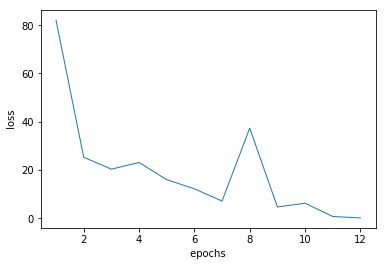

removed junk --

Enter image path   - roadster.png


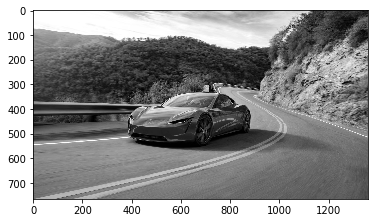

tensor([[ 3.5640, -1.6941]], grad_fn=<AddmmBackward>)
prediction  -  tensor(0)
alpha


 Press Q an then enter to quit, or any other key to continue --  
doggo.png
Enter image path   - doggo.png


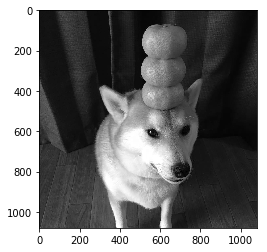

tensor([[-2.7515,  3.0474]], grad_fn=<AddmmBackward>)
prediction  -  tensor(1)
beta 


 Press Q an then enter to quit, or any other key to continue --  
q
-------------------------------------------------------------------------------------------


In [176]:
some_scrapy_boi()

img_processor()

finalise_data()

train_main()

show_analysis()


delete_junk()

classifier_loop()

